# Exploratory Data Analysis (EDA)

```

Tahap ini bertujuan untuk memahami karakteristik dataset barcode detection yang akan digunakan
dalam proses pelatihan model. Analisis ini mencakup distribusi gambar, label, ukuran bounding box, dan contoh visualisasi data.

```

# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2

from pathlib import Path
from PIL import Image, UnidentifiedImageError
from collections import Counter
from matplotlib import patches

### EDA 1 - Cek Struktur Dataset Train

In [2]:
# Path dataset
train_img_dir = Path("dataset/images/train")

# Ambil informasi setiap gambar
train_info = []
for img_path in train_img_dir.glob("*.*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        with Image.open(img_path) as img:
            width, height = img.size
            train_info.append(
                {"filename": img_path.name, "width": width, "height": height}
            )

df_train = pd.DataFrame(train_info)

# 🔹 Tambahan analisis area dan resolusi
df_train["area"] = df_train["width"] * df_train["height"]
df_train["resolution"] = (
    df_train["width"].astype(str) + "x" + df_train["height"].astype(str)
)

# 🔹 Ringkasan deskriptif
print("Jumlah gambar train:", len(df_train))
display(df_train.describe()[["width", "height", "area"]])

# 🔹 Ringkasan tambahan
print(f"\nRata-rata area gambar (pixel): {df_train['area'].mean():,.0f}")
print(f"Resolusi terkecil: {df_train['width'].min()}x{df_train['height'].min()} px")
print(f"Resolusi terbesar: {df_train['width'].max()}x{df_train['height'].max()} px")

# 🔹 Tampilkan resolusi paling sering
print("\nResolusi paling sering digunakan:")
display(df_train["resolution"].value_counts().head())

Jumlah gambar train: 694


,width,height,area
count,694.000000,694.000000,6.940000e+02
mean,783.976945,653.348703,6.635018e+05
std,480.585693,318.878232,7.083812e+05
min,416.000000,416.000000,1.730560e+05
25%,416.000000,416.000000,1.730560e+05
50%,416.000000,416.000000,1.730560e+05
75%,1152.000000,864.000000,9.953280e+05
max,2048.000000,1600.000000,3.145728e+06



Rata-rata area gambar (pixel): 663,502
Resolusi terkecil: 416x416 px
Resolusi terbesar: 2048x1600 px

Resolusi paling sering digunakan:


resolution
416x416      416
1152x864     177
1600x1200     83
2048x1536     15
1200x1600      3
Name: count, dtype: int64

C:\Users\kurni\AppData\Local\Temp\ipykernel_14172\3530897073.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_counts, x="resolution", y="count", palette="Blues_r")


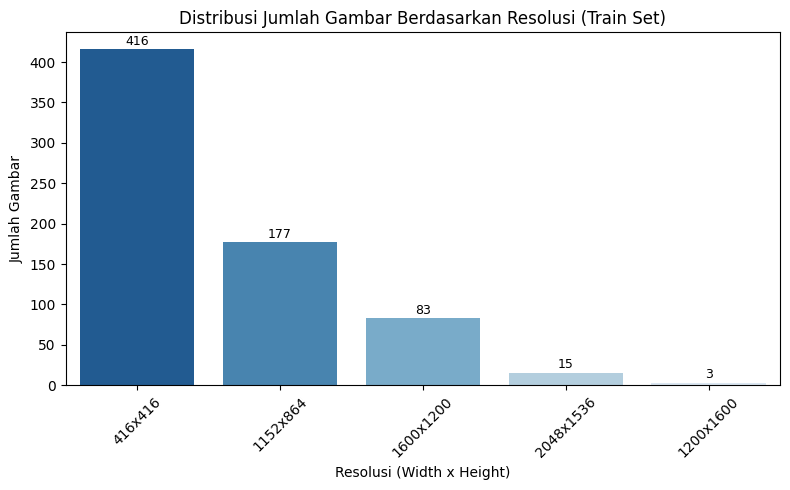

In [3]:
# Hitung jumlah masing-masing resolusi
res_counts = df_train["resolution"].value_counts().reset_index()
res_counts.columns = ["resolution", "count"]

# Visualisasi distribusi resolusi
plt.figure(figsize=(8, 5))
sns.barplot(data=res_counts, x="resolution", y="count", palette="Blues_r")

# Tambahkan angka di atas bar
for i, v in enumerate(res_counts["count"]):
    plt.text(i, v + 2, str(v), ha="center", va="bottom", fontsize=9)

plt.title("Distribusi Jumlah Gambar Berdasarkan Resolusi (Train Set)")
plt.xlabel("Resolusi (Width x Height)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dataset memiliki variasi resolusi yang cukup beragam, mulai dari 416x416 px hingga 2048x1600 px.
- Resolusi 416x416 px mendominasi dataset dengan 416 gambar, menunjukkan bahwa mayoritas data sudah berada dalam format yang sesuai standar YOLO.
- Beberapa gambar beresolusi tinggi seperti 1152x864 px dan 1600x1200 px juga muncul cukup sering, menandakan adanya kombinasi antara citra rendah dan tinggi resolusi.


Kesimpulan:
Distribusi resolusi cukup beragam namun masih didominasi oleh ukuran kecil (416x416), yang baik untuk efisiensi pelatihan YOLO. Namun, keberadaan beberapa gambar resolusi tinggi dapat meningkatkan kemampuan generalisasi model jika dikelola dengan baik (misalnya lewat resize konsisten sebelum training).

### EDA 2 - Distribusi Label pada Train Set

C:\Users\kurni\AppData\Local\Temp\ipykernel_14172\2601605617.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_label, x="class_name", palette="Set2")


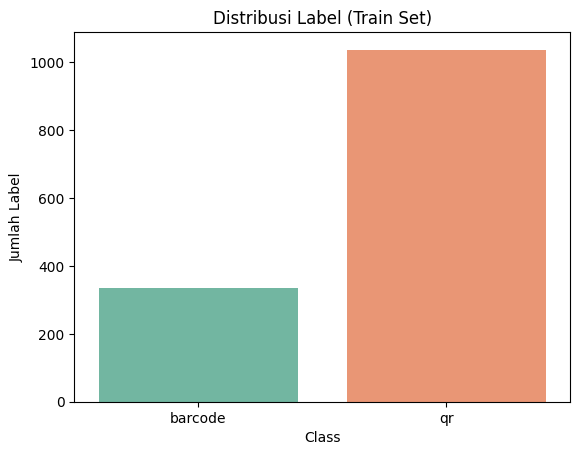

class_name
qr         1037
barcode     335
Name: count, dtype: int64

In [4]:
# Path ke folder label (pastikan sesuai struktur dataset kamu)
train_lbl_dir = Path("dataset/labels/train")

# Hitung jumlah label per kelas
labels = []
for file in train_lbl_dir.glob("*.txt"):
    with open(file, "r") as f:
        for line in f.readlines():
            cls = int(line.strip().split()[0])
            labels.append(cls)

df_label = pd.DataFrame(labels, columns=["class_id"])

# Mapping class
class_map = {0: "barcode", 1: "qr"}
df_label["class_name"] = df_label["class_id"].map(class_map)

# Visualisasi
sns.countplot(data=df_label, x="class_name", palette="Set2")
plt.title("Distribusi Label (Train Set)")
plt.xlabel("Class")
plt.ylabel("Jumlah Label")
plt.show()

df_label["class_name"].value_counts()

Distribusi Label (Train Set)
- Dataset terdiri dari dua kelas utama, yaitu barcode dan qr.
- Kelas qr mendominasi dengan lebih dari 1.000 label, sedangkan barcode hanya sekitar 300 label.
Artinya, terdapat ketidakseimbangan kelas (class imbalance) yang cukup signifikan.

Kesimpulan:
Kelas qr jauh lebih banyak dibanding barcode, sehingga perlu dipertimbangkan strategi seperti oversampling, augmentasi tambahan untuk kelas minoritas, atau class weighting agar model tidak bias terhadap kelas mayoritas.

### EDA 3 - Distribusi Jumlah Objek per Gambar

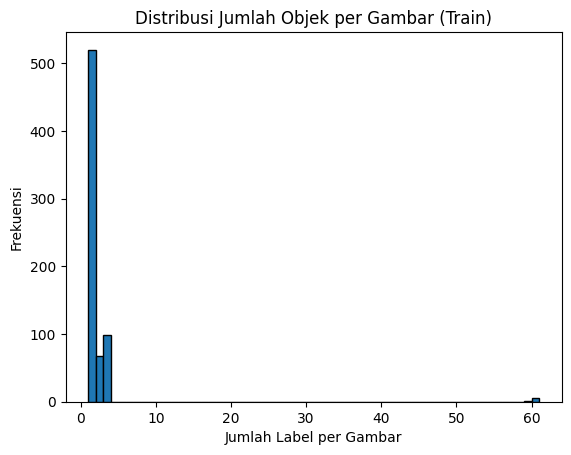

Rata-rata objek per gambar: 1.98


In [5]:
# Hitung jumlah label per file
counts_per_img = []
for file in train_lbl_dir.glob("*.txt"):
    with open(file, "r") as f:
        lines = f.readlines()
        counts_per_img.append(len(lines))

plt.hist(counts_per_img, bins=range(1, max(counts_per_img) + 2), edgecolor="black")
plt.title("Distribusi Jumlah Objek per Gambar (Train)")
plt.xlabel("Jumlah Label per Gambar")
plt.ylabel("Frekuensi")
plt.show()

print(f"Rata-rata objek per gambar: {np.mean(counts_per_img):.2f}")

Distribusi Jumlah Objek per Gambar (Train) :
- Sebagian besar gambar hanya memiliki 1-2 objek, menunjukkan bahwa dataset didominasi oleh gambar dengan sedikit objek terdeteksi.
- Hanya sedikit gambar yang memiliki jumlah objek banyak (outlier sekitar >10 objek, bahkan satu hingga 60 objek).
- Pola ini menandakan distribusi sangat tidak merata sebagian besar gambar sederhana, sementara sebagian kecil jauh lebih kompleks.

Kesimpulan:
Mayoritas gambar memiliki sedikit objek, sehingga model kemungkinan lebih mudah belajar mendeteksi objek tunggal dibandingkan gambar dengan banyak objek.

### EDA 4 - Distribusi Ukuran Bounding Box

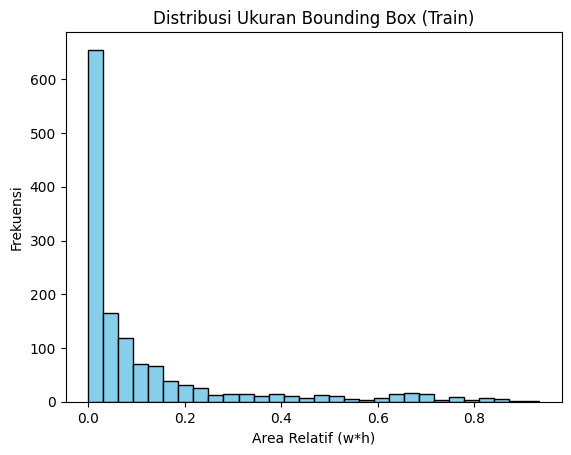

Rata-rata area bbox: 0.1198


In [6]:
bbox_areas = []
for file in train_lbl_dir.glob("*.txt"):
    with open(file, "r") as f:
        for line in f:
            _, x, y, w, h = map(float, line.strip().split())
            bbox_areas.append(w * h)

plt.hist(bbox_areas, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribusi Ukuran Bounding Box (Train)")
plt.xlabel("Area Relatif (w*h)")
plt.ylabel("Frekuensi")
plt.show()

print(f"Rata-rata area bbox: {np.mean(bbox_areas):.4f}")

Distribusi Ukuran Bounding Box (Train) :

- Sebagian besar bounding box memiliki luas relatif kecil terhadap ukuran gambar.
- Hanya sedikit objek yang berukuran besar (area relatif >0.2), menunjukkan bahwa mayoritas objek berukuran kecil di dalam gambar.
- Distribusi ini cenderung right-skewed (condong ke kiri), yang umum terjadi pada dataset deteksi objek.

Kesimpulan:
Model perlu dilatih agar sensitif terhadap objek kecil, karena sebagian besar objek dalam dataset memiliki ukuran kecil dibandingkan dimensi gambar keseluruhan.

### EDA 5 - Rasio Bentuk Bounding Box (Lebar vs Tinggi)

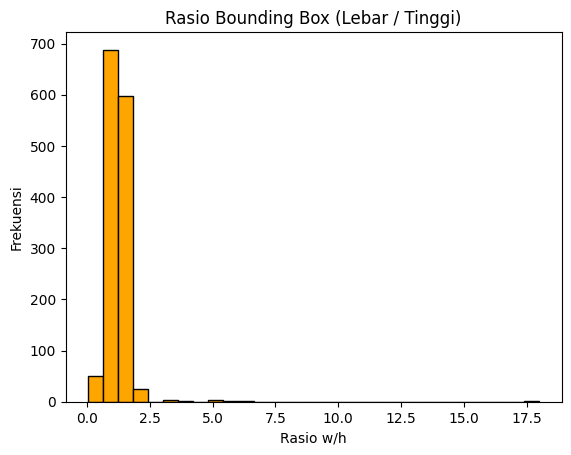

Rata-rata rasio: 1.23


In [7]:
ratios = []
for file in train_lbl_dir.glob("*.txt"):
    with open(file, "r") as f:
        for line in f:
            _, x, y, w, h = map(float, line.strip().split())
            ratios.append(w / h)

plt.hist(ratios, bins=30, color="orange", edgecolor="black")
plt.title("Rasio Bounding Box (Lebar / Tinggi)")
plt.xlabel("Rasio w/h")
plt.ylabel("Frekuensi")
plt.show()

print(f"Rata-rata rasio: {np.mean(ratios):.2f}")

Rasio Bounding Box (Lebar / Tinggi)
- Mayoritas bounding box memiliki rasio w/h antara 0.5 hingga 2, menunjukkan bahwa bentuk objek cenderung mendekati persegi.
- Hanya sedikit objek dengan rasio ekstrem (>5), yang berarti objek memanjang secara horizontal atau vertikal sangat jarang.
- Distribusi yang terpusat di sekitar 1 mengindikasikan proporsi objek cukup seragam, memudahkan model dalam generalisasi bentuk.

Kesimpulan:
Sebagian besar objek memiliki bentuk yang proporsional (tidak terlalu lebar atau tinggi), sehingga model dapat fokus pada variasi ukuran tanpa terlalu banyak penyesuaian aspek rasio.

### EDA 6 - Distribusi Tipe Barcode/QR (Sub-Class)

,Count
Class,
QR Code,1037
EAN-13,335


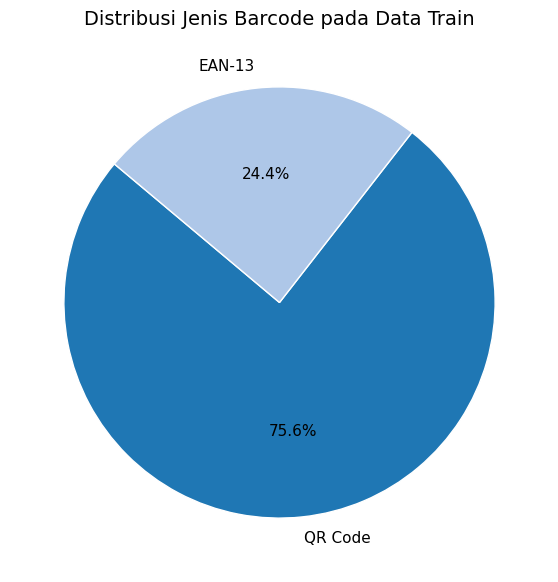

In [8]:
# Path label untuk train
label_dir = "dataset/labels/train"

# Mapping ID ke nama kelas (ubah sesuai dataset kamu)
class_map = {
    0: "EAN-13", 
    1: "QR Code", 
    2: "Code 128", 
    3: "Code 39", 
    4: "UPC-A"}

# Hitung jumlah kemunculan setiap class dari file label YOLO (.txt)
class_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), "r") as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_name = class_map.get(class_id, f"Unknown-{class_id}")
                class_counts[class_name] += 1

# Konversi hasil ke dataframe
df_label_dist = pd.DataFrame.from_dict(class_counts, orient="index", columns=["Count"])
df_label_dist.index.name = "Class"
df_label_dist = df_label_dist.sort_values("Count", ascending=False)
display(df_label_dist)

# Plot pie chart dengan label nama kelas
plt.figure(figsize=(7, 7))
colors = plt.cm.tab20.colors  # palet warna otomatis
plt.pie(
    df_label_dist["Count"],
    labels=df_label_dist.index,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"edgecolor": "white"},
    textprops={"fontsize": 11},
    colors=colors,
)
plt.title("Distribusi Jenis Barcode pada Data Train", fontsize=14)
plt.show()

Dataset train menunjukkan bahwa QR Code mendominasi data sebesar 75,6%, sedangkan EAN-13 hanya 24,4%.
Hal ini menandakan adanya ketidakseimbangan kelas (class imbalance) yang dapat memengaruhi kinerja model dalam mendeteksi barcode. Oleh karena itu, diperlukan penyeimbangan data melalui augmentation atau class weighting agar model tidak bias terhadap jenis barcode tertentu.

### EDA 7 - Visualisasi Contoh Gambar dengan Bounding Box

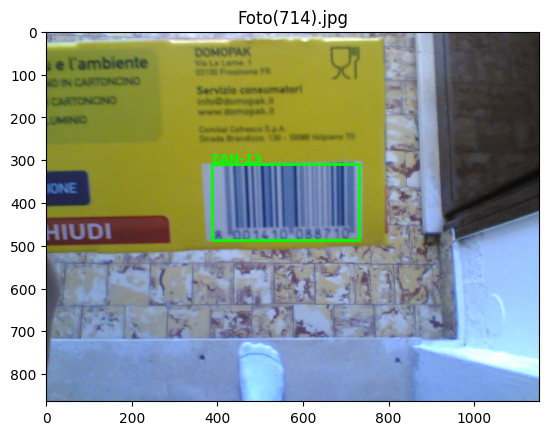

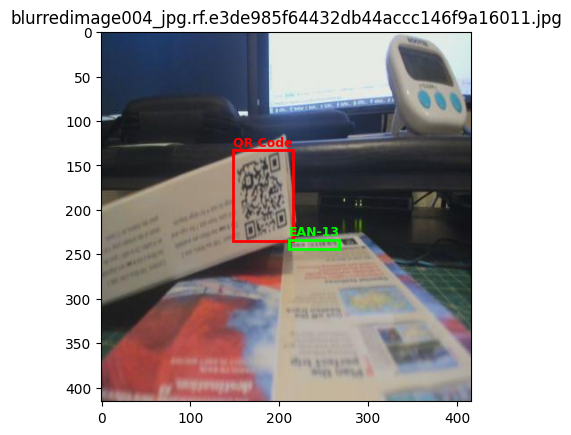

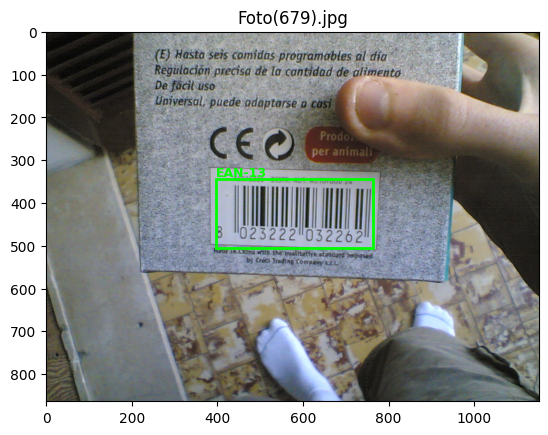

In [9]:
def visualize_samples(n=3):
    sample_files = random.sample(list(train_img_dir.glob("*.jpg")), n)
    for img_path in sample_files:
        label_path = train_lbl_dir / (img_path.stem + ".txt")

        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        fig, ax = plt.subplots(1)
        ax.imshow(img)

        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1 = (x - bw / 2) * w
                    y1 = (y - bh / 2) * h
                    bw *= w
                    bh *= h
                    color = "lime" if int(cls) == 0 else "red"
                    rect = patches.Rectangle(
                        (x1, y1), bw, bh, linewidth=2, edgecolor=color, facecolor="none"
                    )
                    ax.add_patch(rect)
                    ax.text(
                        x1,
                        y1 - 5,
                        class_map[int(cls)],
                        color=color,
                        fontsize=9,
                        weight="bold",
                    )
        plt.title(img_path.name)
        plt.show()


visualize_samples(3)

Visualisasi ini memastikan bahwa anotasi bounding box sudah tepat. Jika ada label yang meleset atau keluar dari objek, berarti ada kesalahan anotasi yang perlu diperbaiki sebelum training.

### EDA 8 - Pengecekan Kualitas File (Corrupt Image Detection)

Jumlah gambar corrupt: 0


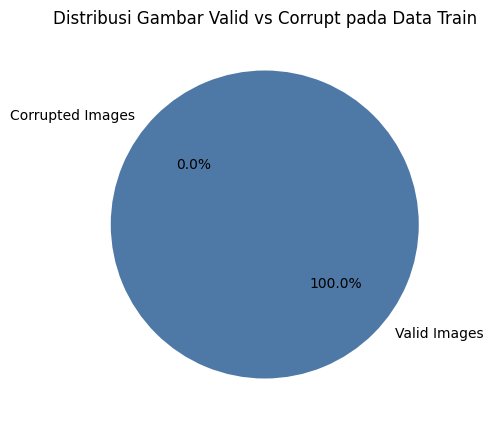

In [10]:
corrupted = []
for img_path in train_img_dir.glob("*.jpg"):
    try:
        img = Image.open(img_path)
        img.verify()
    except (UnidentifiedImageError, OSError):
        corrupted.append(str(img_path))

print(f"Jumlah gambar corrupt: {len(corrupted)}")
if corrupted:
    print(corrupted[:5])

# Total gambar
total_images = len(list(train_img_dir.glob("*.jpg")))

# Jumlah gambar corrupt
num_corrupt = len(corrupted)
num_valid = total_images - num_corrupt

# Buat data untuk visualisasi
labels = ["Valid Images", "Corrupted Images"]
sizes = [num_valid, num_corrupt]
colors = ["#4e79a7", "#f28e2b"]

# Plot
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title("Distribusi Gambar Valid vs Corrupt pada Data Train")
plt.show()

Jadi hasilnya nol, berarti semua gambar train valid dan bisa diproses model. Dan jika ada file corrupt, perlu dihapus atau diganti agar tidak menyebabkan error saat training.